<a href="https://colab.research.google.com/github/leoliuuu/PokerCardClassification/blob/main/PokerCards_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchviz
import gdown, os, shutil
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np # we always love numpy

     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=07f22cf6df28652c4b651deddfd3b2a2710f542d69ccba91caf12220bf81ad8f
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [ ]:
gdown.download('https://drive.google.com/uc?authuser=0&id=1wJUqN8aBmCHfffxVQIU-jIbKUJ2gTmIi&export=download', 'playing_cards.zip', quiet=False)
!unzip -qq playing_cards.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1wJUqN8aBmCHfffxVQIU-jIbKUJ2gTmIi&export=download
To: /content/playing_cards.zip
548MB [00:02, 227MB/s]


## Setting up dataset for classification

In [ ]:
source_path = './playing-cards-master/img'
dest_path = './playing-cards-master/

if os.path.exists(source_path):
  cards = os.listdir(source_path)

  # Determine card classes within img directory
  classes = set()
  indexes = defaultdict(list)
  for idx, card in enumerate(cards):
    if '[' in card and ']' in card:
      start = card.find('[')
      end = card.find(']')
      c = card[start+1:end]
      classes.add(c)
      indexes[c].append(idx)

  # Create class directories
  for c in classes:
    if not os.path.exists(dest_path + c): 
      os.mkdir(dest_path + c)

  # Move images to corresponding directory
  for key, values in indexes.items():
    for i in values:
      shutil.move(source_path+'/'+cards[i], dest_path+key)

  # Delete img directory
  os.rmdir(source_path)
  classes = list(classes) # TODO: Maybe don't need, b/c of playing_cards.classes

In [ ]:
len(classes)

54

In [ ]:
def show_image(img_tensor):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.show()

In [ ]:
# image_dims = [3, 2322, 4128]
image_dims_og = [3, 2322, 4128]
resize = 32
image_dims = [3, 98, 98]
image_dims

[3, 98, 98]

## Data Cache

In [ ]:
# Datasets must always subclass either Dataset (either directly or indirectly)
# Here, we use subclass the ImageFolder class.
class CachedDataset(ImageFolder):
    def __init__(self, root, move_to_GPU=False, transform=None, target_transform=None):
        """ The init method passes most arguments up to the `ImageFolder` class.

            The exception is the `move_to_GPU` input, which if set to true will
            move the returned data to CUDA and if false, will keep it on the CPU
        """
        # make sure to call the super class init method
        super(CachedDataset, self).__init__(root,
                                            transform=transform,
                                            target_transform=target_transform)
        self.total_time_loading = 0
        self.move_to_GPU = move_to_GPU
        # we'll cache the loaded tensors here
        self.tensor_cache = {}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        t_start = time.time()
        if int(index) in self.tensor_cache:
            self.total_time_loading += time.time() - t_start
            return self.tensor_cache[int(index)]

        inputs, target = super(CachedDataset, self).__getitem__(index)
        if self.move_to_GPU:
            self.tensor_cache[int(index)] = inputs.to('cuda'), target
        else:
            self.tensor_cache[int(index)] = inputs, target
        self.total_time_loading += time.time() - t_start
        return self.tensor_cache[int(index)]

In [ ]:
# playing_cards = ImageFolder(root='./playing-cards-master',transform=transforms.Compose([
#   transforms.Resize(99),
#   transforms.CenterCrop(98),
#   transforms.ToTensor()
# ]))

In [ ]:
playing_cards = CachedDataset(root='./playing-cards-master',transform=transforms.Compose([
  transforms.Resize(99),
  transforms.CenterCrop(98),
  transforms.ToTensor()
]))

In [ ]:
# playing_cards = ImageFolder(root='./playing-cards-master',transform=transforms.Compose([transforms.ToTensor()]))

W2
torch.Size([3, 98, 98])


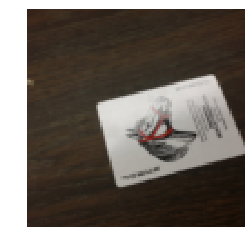

In [ ]:
im, target = playing_cards[215]
print(playing_cards.classes[target])
print(im.shape)
show_image(im)

In [ ]:
# for i, t in playing_cards:
#   _, width, height = i.shape
#   if width != 98 or height != 98:
#     print('Error: wrong shape')
#     break

In [ ]:
# Training/Validation Dataset split

n_train = 54*3 # 54 b/c of two wildcard classes
indices = torch.randperm(len(playing_cards))

from sklearn.model_selection import StratifiedShuffleSplit
s = StratifiedShuffleSplit(n_splits=1, test_size=.25)
split = s.split(playing_cards.imgs, playing_cards.targets)
train_idx, test_idx = next(split)
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Define training parameters
batch_size = 32
learning_rate = 1e-1
n_epochs = 20

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(playing_cards, batch_size=batch_size,
                                        sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(playing_cards, batch_size=128,
                                        sampler=test_sampler)

In [ ]:
len(playing_cards)

216

## Test 1: Basic CNN Implementation

In [ ]:
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here

        # Make sure you understand what this convolutional layer is doing.
        # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
        # this layer does to the data.

        # note: image_dims[0] will be 3 as there are 3 color channels (R, G, B)
        num_kernels = 16
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)

        # Make sure you understand what this MaxPool2D layer is doing.
        # E.g., considering looking at help(nn.MaxPool2d).  Draw a picture of
        # what this layer does to the data.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.  We have an exercise that asks you to explain why the line of
        # code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(classes)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # Note: that the output will not represent the probability of the
        # output being in each class.  The loss function we will use
        # `CrossEntropyLoss` will take care of convering these values to
        # probabilities and then computing the log loss with respect to the
        # true label.  We could break this out into multiple steps, but it turns
        # out that the algorithm will be more numerically stable if we do it in
        # one go.  We have included a cell to show you the documentation for
        # `CrossEntropyLoss` if you'd like to check it out.
        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

## Visualizing Network

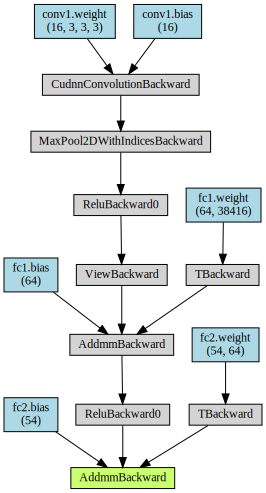

In [ ]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

visualize_network(net)

## Training

In [ ]:
def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 1
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
      
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):

            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            t_start = time.time()
            outputs = net(inputs)
            print("forward time", time.time() - t_start)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            t_start = time.time()
            loss_size.backward()
            print("backward time", time.time() - t_start)
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [ ]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

forward time 0.0019137859344482422
backward time 0.0277402400970459
Epoch 1, Iteration 1	 train_loss: 3.97 took: 6.65s
forward time 0.0005660057067871094
backward time 0.0011692047119140625
Epoch 1, Iteration 2	 train_loss: 4033.68 took: 6.56s
forward time 0.0006172657012939453
backward time 0.0007853507995605469
Epoch 1, Iteration 3	 train_loss: 865.83 took: 6.32s
forward time 0.0006091594696044922
backward time 0.0007622241973876953
Epoch 1, Iteration 4	 train_loss: 13.24 took: 6.48s
forward time 0.0005886554718017578
backward time 0.0007650852203369141
Epoch 1, Iteration 5	 train_loss: 38.59 took: 6.51s
forward time 0.0005900859832763672
backward time 0.0007843971252441406
Epoch 1, Iteration 6	 train_loss: 39.84 took: 0.41s
Validation loss = 4.01
forward time 0.0006763935089111328
backward time 0.00106048583984375
Epoch 2, Iteration 1	 train_loss: 4.03 took: 0.01s
forward time 0.0004775524139404297
backward time 0.0008220672607421875
Epoch 2, Iteration 2	 train_loss: 4.02 took: 0.01

In [ ]:
#!nvidia-smi

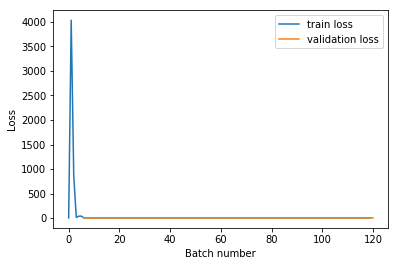

In [ ]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

In [ ]:
def disp_image(image, class_idx, predicted=None):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(image.transpose(0,2).transpose(0,1))
    plt.axis('off')
    if predicted:
        plt.title("Actual: " + playing_cards.classes[class_idx] + "     Predicted: " + playing_cards.classes[predicted])
    else:
        plt.title("Actual: " + playing_cards.classes[class_idx])
    plt.show()

In [ ]:
def test_labels(idx):
    image, label = playing_cards[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    # disp_image(image, label, prediction)
    return label, prediction
  
for i in range(len(playing_cards)):
  label, prediction = test_labels(i)
  if label == prediction:
    print(i, label, prediction)

204 51 51
205 51 51
206 51 51
207 51 51


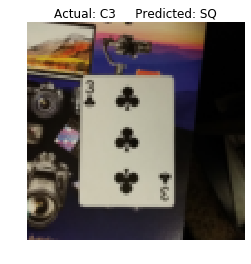

In [ ]:
def examine_label(idx):
    image, label = playing_cards[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    disp_image(image, label, prediction)

examine_label(10)

In [ ]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        # print("Output", np.argmax(outputs.cpu().detach().numpy(), axis=1))
        # print("Actual Label", labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))

Train accuracy is 0.018518518518518517
Test accuracy is 0.018518518518518517
